# Turing.jl

Turing.jl is a probabilistic programming in Julia. If you are familiar with Stan or PyMC, you will quickly feel at home with Turing.jl.

Like all probabilistic programming languages, Turing.jl's goal is to make Bayesian inference easy by decoupling statistical models and inference algorithms: You can write your model using an intuitive syntax that looks like maths, and use many different inference methods on it without understanding the details of the methods.

Turing's design principles resembles those of Julia's: You can do almost anything, and if you write your code with care it can be blazing fast. This is its greatest departure from Stan: Stan imposes strict constraints on what can be included in a model and how one can perform inference. Turing is far more flexible, for better and for worse.

Turing's greatest strength is its integration with the wider Julia scientific computing ecosystem: Distributions.jl, DifferentialEquations.jl, and several automatic differentiation packages interoperate well with Turing. You'll see some examples of this in the course of the afternoon.

This tutorial will introduce you to Turing in a hands-on manner. We will
1. Cover some examples of basic usage of Turing.jl
2. Let you try out writing your own models
3. Go through some slightly more advanced usage
4. Talk about state space models, and how they work with Turing

## Basics: How to write a model

For a toy problem, let's assume we have a loaded 6-sided die, and we want to figure out the probability distribution of it landing on each of its 6 sides.

In [ ]:
import Pkg
Pkg.activate(".")

In [34]:
# You only need to run these once, to install packages.
# If you e.g. restart your kernel, you can skip this cell.
Pkg.add("Distributions")
Pkg.add("Turing")
Pkg.add("StatsPlots")
Pkg.add("Plots")
Pkg.add("DataFrames")

   Resolving package versions...
     Project No packages added to or removed from `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/Project.toml`
    Manifest No packages added to or removed from `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/Project.toml`
    Manifest No packages added to or removed from `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/Project.toml`
    Manifest No packages added to or removed from `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/Proj

First, let's create the die and generate some data from it, to which we can fit our model.

mean(dice) = 4.5
mode(dice) = 6


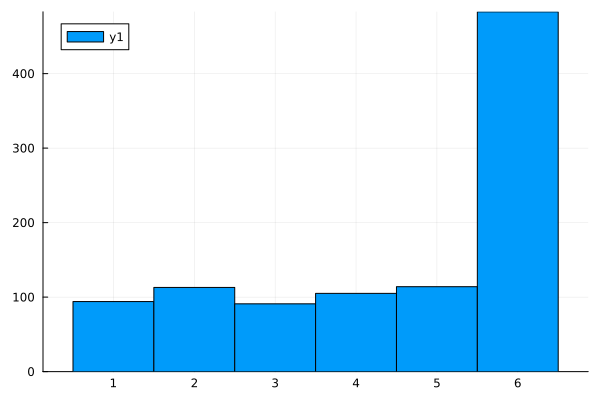

In [2]:
using Distributions
using StatsPlots
using Plots
using Random

Random.seed!(23)

dice = Categorical([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])

@show mean(dice)
@show mode(dice)

data = rand(dice, 1_000)
histogram(data, bins=0.5:1:6.5)

Here's how we can model a 6-sided die in Turing.

In [3]:
using Turing

@model function dice_throw(num_throws)
    # Random variable p is a 6-dimensional vector
    # with the probabilities for the 6 different outcomes.
    # It's prior distribution is set to be Dirichlet(6, 1),
    # which is uniform.
    #
    # The ~ statement is the only new addition to normal Julia
    # syntax introduced by the @model macro from Turing. It reads
    # as "p is distributed according to Dirichlet(6, 1)".
    # It also sets the variable p to value, which by default
    # is sampled from the distribution.
    p ~ Dirichlet(6, 1)

    # throws is the random variable for the outcomes of throws.
    # It's distribution is Categorical(p) for each throw.
    throws ~ product_distribution([Categorical(p) for _ in 1:num_throws])
end

# With the model defined, we can instantiate a model with our data
my_model = dice_throw(length(data)) | (; throws=data)
# The | denotes conditioning. The above is equivalent with
# my_model = condition(dice_throw(length(data)); throws=data)

DynamicPPL.Model{typeof(dice_throw), (:num_throws,), (), (), Tuple{Int64}, Tuple{}, DynamicPPL.ConditionContext{@NamedTuple{throws::Vector{Int64}}, DynamicPPL.DefaultContext}}(Main.dice_throw, (num_throws = 1000,), NamedTuple(), ConditionContext((throws = [5, 6, 6, 2, 5, 6, 3, 6, 1, 2, 5, 1, 6, 6, 4, 6, 2, 6, 6, 6, 6, 4, 6, 6, 6, 6, 3, 3, 6, 6, 4, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 3, 2, 2, 4, 3, 1, 2, 6, 6, 6, 6, 4, 1, 6, 5, 1, 6, 6, 6, 5, 4, 6, 5, 6, 2, 6, 6, 6, 2, 6, 1, 6, 6, 6, 6, 6, 3, 6, 4, 6, 1, 6, 6, 6, 3, 5, 6, 5, 6, 1, 4, 4, 1, 2, 4, 6, 2, 5, 6, 1, 5, 5, 6, 6, 5, 3, 6, 5, 3, 2, 6, 6, 6, 4, 2, 6, 6, 5, 3, 6, 6, 6, 2, 5, 6, 6, 3, 6, 6, 2, 1, 1, 1, 6, 6, 1, 6, 6, 5, 2, 5, 1, 5, 6, 6, 6, 6, 6, 6, 5, 2, 1, 5, 3, 3, 6, 2, 5, 6, 5, 4, 2, 6, 2, 6, 1, 5, 4, 6, 5, 6, 2, 6, 6, 6, 6, 6, 3, 1, 6, 6, 1, 6, 2, 5, 3, 6, 6, 6, 5, 6, 6, 2, 2, 6, 5, 6, 2, 5, 6, 6, 6, 5, 4, 6, 3, 5, 4, 4, 6, 1, 4, 4, 6, 6, 6, 1, 3, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 3, 1, 6, 6, 6, 3, 3, 5, 6, 6, 3, 6, 5, 6, 6, 6, 3, 3, 6,

## Basics: Inference

Let's sample from the posterior of `my_model` using a Markov Chain Monte Carlo sampler called NUTS.

In [4]:
chain_nuts = sample(my_model, NUTS(), 1_000)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
Sampling   1%|▎                                         |  ETA: 0:13:42
Sampling   1%|▍                                         |  ETA: 0:07:20
Sampling   2%|▋                                         |  ETA: 0:04:46
Sampling   2%|▉                                         |  ETA: 0:03:39
Sampling   3%|█▏                                        |  ETA: 0:02:53
Sampling   3%|█▎                                        |  ETA: 0:02:26
Sampling   4%|█▌                                        |  ETA: 0:02:03
Sampling   4%|█▋                                        |  ETA: 0:01:50
Sampling   5%|█▉                                        |  ETA: 0:01:37
Sampling   5%|██▏                                       |  ETA: 0:01:28
Sampling   6%|██▍                                       |  ETA: 0:01:19
Sampling   6

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 7.98 seconds
Compute duration  = 7.98 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


`chain_nuts` contains 1000 samples from the posterior, which we can investigate in various ways:

In [5]:
describe(chain_nuts)

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 7.98 seconds
Compute duration  = 7.98 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics

  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

        p[1]    0.0941    0.0093    0.0003   1375.6826   722.5122    0.9995    ⋯
        p[2]    0.1127    0.0099    0.0002   1999.6759   795.0140    1.0000    ⋯
        p[3]    0.0914    0.0095    0.0002   1645.0289   907.1162    1.0068    ⋯
        p[4]    0.1058    0.0096    0.0002   1854.5645   757.0788    1.0086    ⋯
        p[5]  

In [6]:
quantile(chain_nuts)

Quantiles

  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        p[1]    0.0766    0.0875    0.0940    0.1002    0.1129
        p[2]    0.0949    0.1057    0.1127    0.1192    0.1327
        p[3]    0.0732    0.0851    0.0911    0.0978    0.1097
        p[4]    0.0873    0.0994    0.1059    0.1115    0.1254
        p[5]    0.0942    0.1066    0.1139    0.1217    0.1361
        p[6]    0.4508    0.4709    0.4822    0.4927    0.5128



You can make all sorts of plots from the data yourself, but simply calling `plot(chain_nuts)` gives you trace plots to see that sampling has converged, and density plots of the marginals of each variable, for a quick overview.

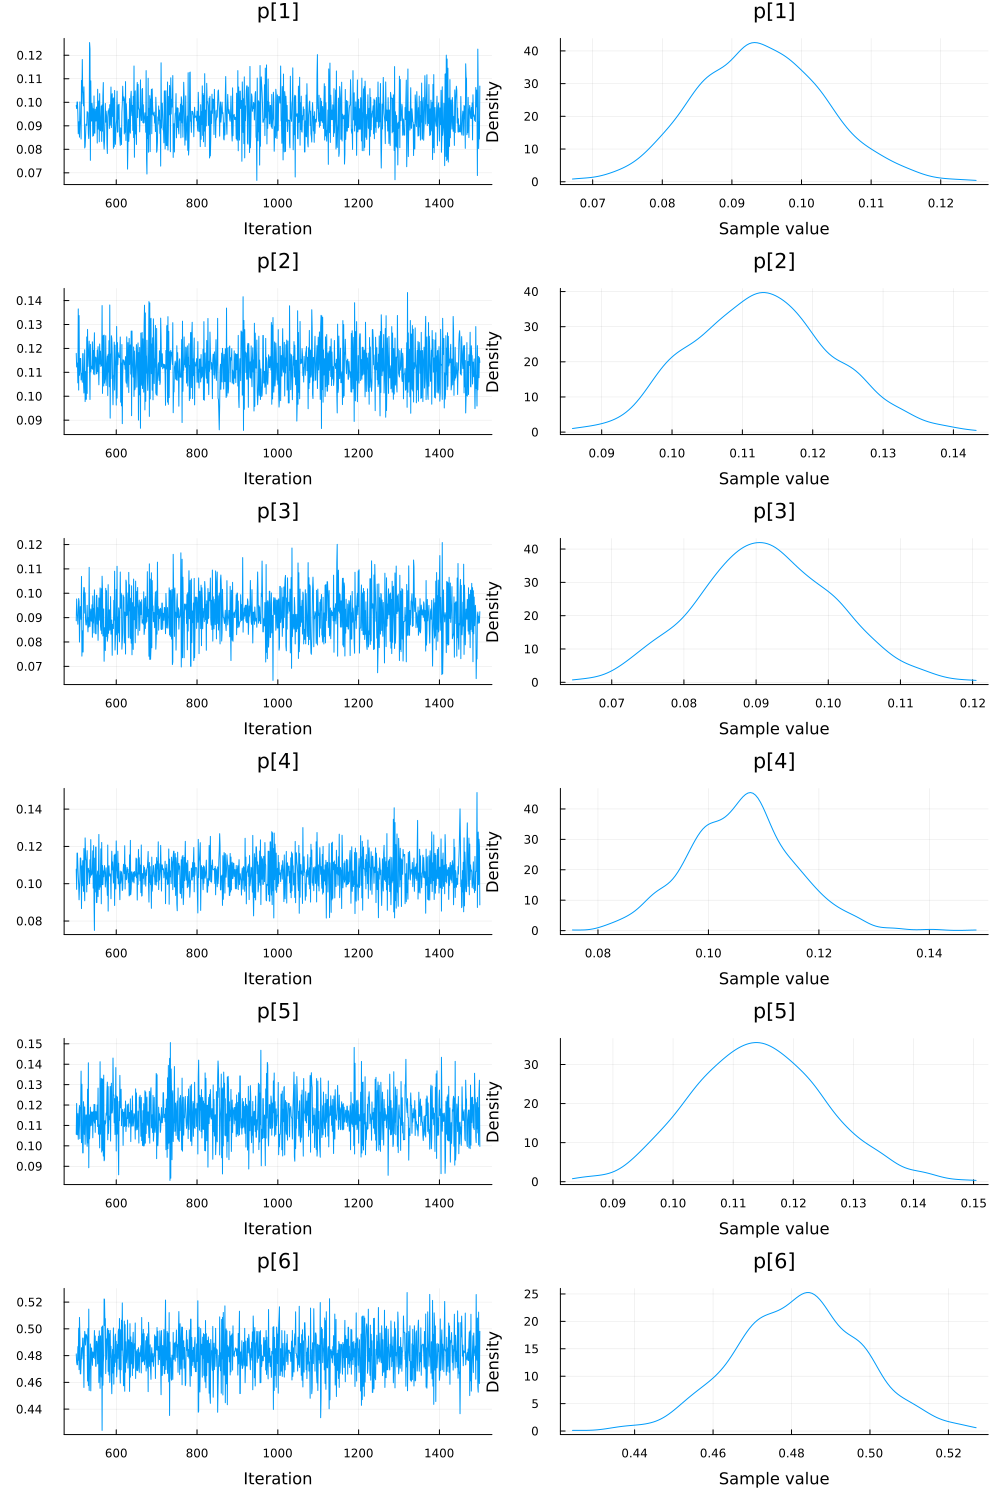

In [7]:
plot(chain_nuts)

You can also convert the whole chain into a `DataFrame`, and do all the usual statistical analysis you would on a `DataFrame`. Note that the columns include not just the values of all our random variables `p[i]`, but also various diagnostics from the sampler. We can ignore them for now.

In [8]:
using DataFrames
DataFrame(chain_nuts)

1000×22 DataFrame
  Row │ iteration  chain  p[1]       p[2]      p[3]       p[4]       p[5]      ⋯
      │ Int64      Int64  Float64    Float64   Float64    Float64    Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │       501      1  0.0986342  0.117924  0.0887105  0.107801   0.105659  ⋯
    2 │       502      1  0.0973215  0.112238  0.0976427  0.0969802  0.120769
    3 │       503      1  0.100124   0.113848  0.0910006  0.116412   0.105453
    4 │       504      1  0.100124   0.113848  0.0910006  0.116412   0.105453
    5 │       505      1  0.0950036  0.105587  0.0872764  0.109603   0.115814  ⋯
    6 │       506      1  0.0865877  0.136505  0.093249   0.10391    0.103207
    7 │       507      1  0.0903524  0.102585  0.0978452  0.0993401  0.109377
    8 │       508      1  0.0917751  0.133725  0.0967226  0.0913689  0.116904
  ⋮   │     ⋮        ⋮        ⋮         ⋮          ⋮          ⋮          ⋮     ⋱
  994 │      1494      1  0.068867   0.121162  0.0908645  0.0872666  0.123777  ⋯
  995 │      1495      1  0.122607   0.102684  0.0922944  0.11932    0.10634
  996 │      1496      1  0.10407    0.109276  0.0876423  0.127693   0.118674
  997 │      1497      1  0.0803352  0.116643  0.0905872  0.0994728  0.100442
  998 │      1498      1  0.0917509  0.107747  0.0892474  0.123852   0.12675   ⋯
  999 │      1499      1  0.0843979  0.116118  0.0878426  0.120343   0.132152
 1000 │      1500      1  0.106888   0.114135  0.0924427  0.0886448  0.0997173
                                                 15 columns and 985 rows omitted

You can easily run multiple chains in parallel, like so:

In [9]:
chains_nuts = sample(my_model, NUTS(), MCMCThreads(), 1_000, 4; progress=false)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/mhauru/.julia/packages/AbstractMCMC/mcqES/src/sample.jl:432
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220


Chains MCMC chain (1000×20×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 13.79 seconds
Compute duration  = 13.71 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


We used NUTS as our MCMC sampler above. It's a good default, and the main sampler in Stan. However, Turing also offers many other samplers, such as Metropolis-Hastings, particle Gibbs, elliptical slice sampling, and any combinations thereof within a Gibbs sampler. We'll touch on this a bit later, but just to demonstrate, switching samplers is as easy as

In [10]:
# Using Metropolis-Hastings
chain_mh = sample(my_model, MH(), 1_000; progress=false)

Chains MCMC chain (1000×9×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1.26 seconds
Compute duration  = 1.26 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


Just because you can sample with a sampler, doesn't mean that the results are any good. Do check the outcome. For instance, in this case, the Metropolis-Hastings sampler makes very slow progress, as can be seen from the effective sample size (ESS) and the trace plots:

In [11]:
describe(chain_mh)

Chains MCMC chain (1000×9×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1.26 seconds
Compute duration  = 1.26 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = lp, logprior, loglikelihood

Summary Statistics

  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        p[1]    0.1248    0.0306    0.0083    15.6977    10.3620    1.0019     ⋯
        p[2]    0.1218    0.0346    0.0113    12.9103    14.7367    1.0517     ⋯
        p[3]    0.1290    0.0582    0.0229     5.7009     8.7257    1.1936     ⋯
        p[4]    0.1028    0.0239    0.0055    15.1480     6.8435    1.1750     ⋯
        p[5]    0.1196    0.0425    0.0114    14.5507     7.2784    1.0244     ⋯
        p[6]    0.4020    0.0635    0.0205    13.1039     5.7259    1.5472     ⋯

                                   

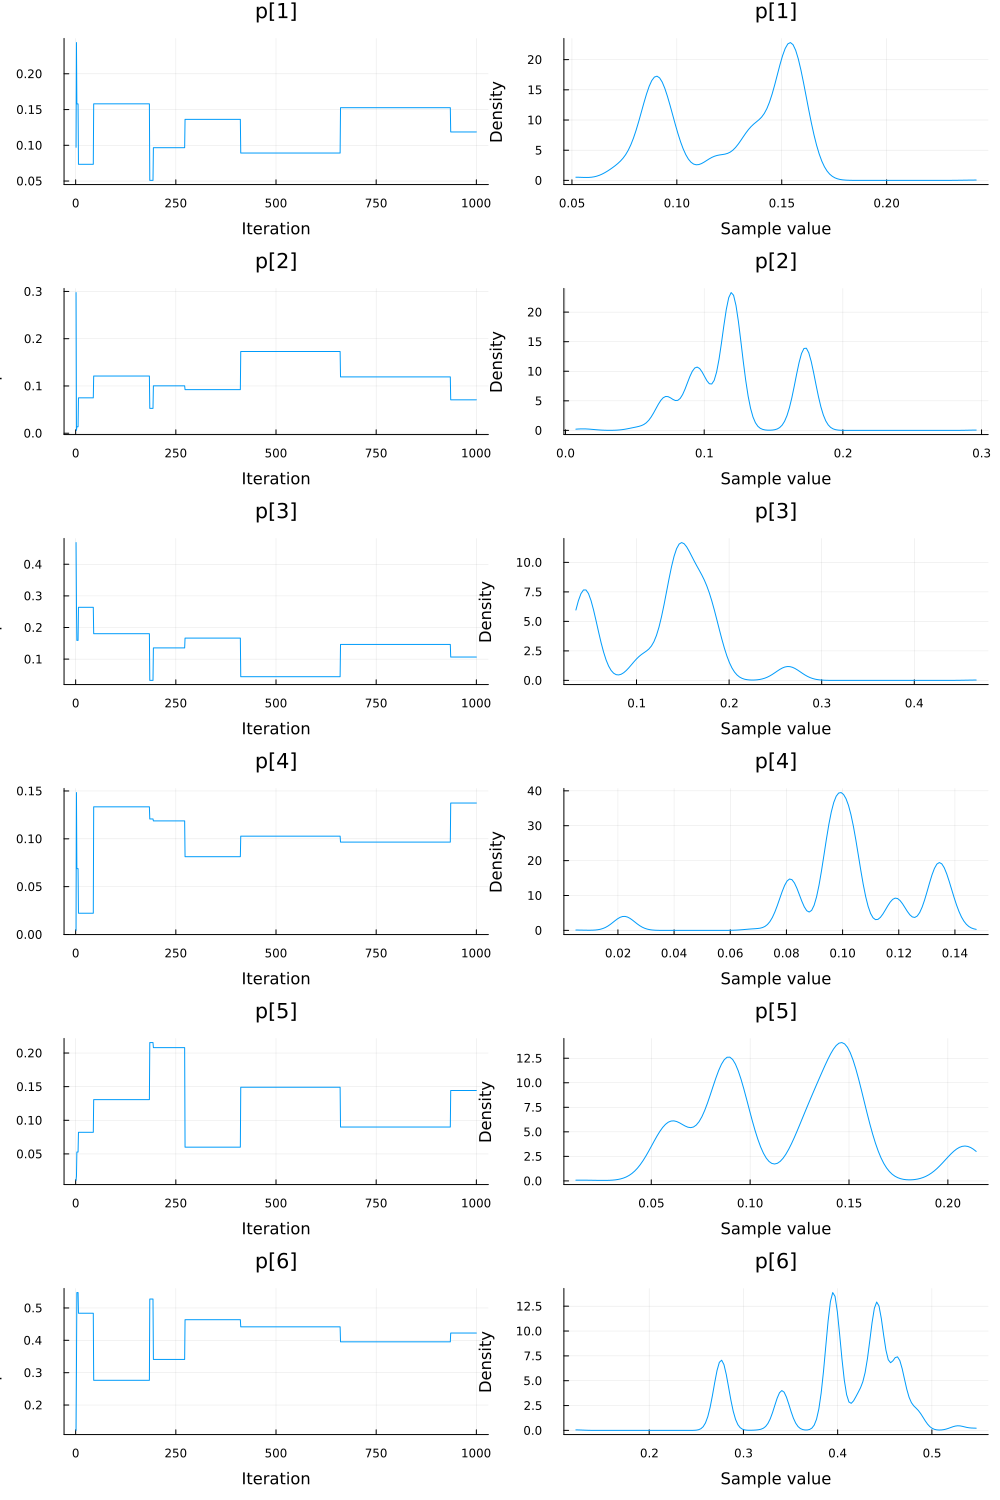

In [12]:
plot(chain_mh)


This could be fixed by tuning the sampler, but that's for later.

In our example model, we wrote everything in terms of multidimensional variables, with multidimensional distributions as priors. 

In [13]:
@model function dice_throw(num_throws)
    p ~ Dirichlet(6, 1)
    throws ~ product_distribution([Categorical(p) for _ in 1:num_throws])
end

dice_throw (generic function with 2 methods)

That's usually a good idea. However, for convenience, Turing also supports indexing into variables, so that the same model could also be written as.

In [14]:
@model function dice_throw_with_indexing(num_throws)
    p ~ Dirichlet(6, 1)
    throws = Vector{Float64}(undef, num_throws)
    for i in eachindex(throws)
        throws[i] ~ Categorical(p)
    end
end

dice_throw_with_indexing (generic function with 2 methods)

## Exercise: Linear regression

Task: Write a one-variable linear regression model in Turing, give it some made up data, and recover the original parameters used to make the data.

There are many ways to do this, but you probably want a model with two or three parameters, for the slope and intercept of the fit and possibly also for the scale of noise in your data.

Here are the true parameters we want to recover, and some dummy data:

In [15]:
true_slope = 5.4
true_intercept = -0.3
true_noise_variance = 2.3
num_points = 2_000
predictors = rand(num_points)
data = true_slope .* predictors .+ true_intercept .+ randn(num_points) .* sqrt(true_noise_variance)

2000-element Vector{Float64}:
  6.858205465566453
  1.4760959369664328
  3.5039341298720275
  6.799673179803108
  3.7478921342638487
  3.840983760894777
  3.226510540434692
 -0.38709260060653455
 -1.9754517717402014
  2.9420041487789144
  ⋮
  1.159742948805093
  3.582300538897348
  1.1072324696140776
  2.8717131874186443
  1.4584370205451305
 -0.066814626702564
  2.22870440052253
  3.0209140681539988
  4.95599469925942

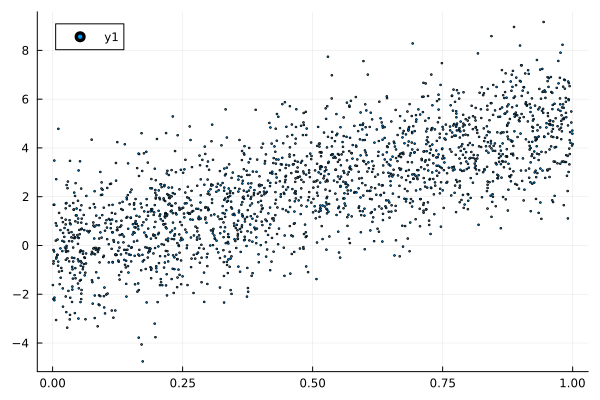

In [16]:
scatter(predictors, data, ms=1)

And here's a template for you to fill in.

In [17]:
# Write a model to recover the slope, intercept, and noise variance from predictors and data.

@model function # TODO This function needs a name and arguments
    # TODO Fill me in please
end

# TODO Sample from the above model to find the posterior distribution for the parameters.

Base.Meta.ParseError: ParseError:
# Error @ /Users/mhauru/projects/TuringLang/Turing-Workshop/2025-CFE-CMStatistics/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X56sZmlsZQ==.jl:5:1
    # TODO Fill me in please
end
└─┘ ── invalid identifier

In [18]:
# Solution below, but first some empty space to stop accidental spoilers.
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD

Here's one solution:

In [19]:
# Write a model to recover the slope, intercept, and noise variance from predictors and data.

@model function linear_regression(predictors)
    slope ~ Normal(0.0, 10.0)
    intercept ~ Normal(0.0, 10.0)
    noise_variance ~ Exponential(0.5)

    mean = slope .* predictors .+ intercept
    # The below is equivalent to
    # data ~ product_distribution([Normal(mean[i], sqrt(noise_variance) for i in 1:length(predictors)])
    # MvNormal is just a convenience function for creating multivariate normal distributions.
    data ~ MvNormal(mean, I*noise_variance)
end

lr_model = linear_regression(predictors) | (; data=data)
lr_chain = sample(lr_model, NUTS(), MCMCThreads(), 1_000, 3; progress=false)
quantile(lr_chain)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/mhauru/.julia/packages/AbstractMCMC/mcqES/src/sample.jl:432
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220


Quantiles

      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

           slope    5.2070    5.3572    5.4372    5.5163    5.6520
       intercept   -0.4252   -0.3467   -0.3024   -0.2562   -0.1650
  noise_variance    2.1789    2.2596    2.3117    2.3630    2.4676



## Basics: Studying results

Turing has various features for studying models and inference results. Let's see how they apply to the linear regression model above.

We saw a bit of this already: The chains returned by sample include various sampler statistics. These can be found under the `:internals` section:

In [20]:
mean(lr_chain; sections = :internals)

Mean

                    parameters         mean 
                        Symbol      Float64 

                       n_steps       6.7140
                     is_accept       1.0000
               acceptance_rate       0.8502
                   log_density   -3689.4904
            hamiltonian_energy    3690.9800
      hamiltonian_energy_error      -0.0010
  max_hamiltonian_energy_error       0.2645
                    tree_depth       2.5287
               numerical_error       0.0000
                     step_size       0.5339
                 nom_step_size       0.5339
                            lp   -3690.3285
                      logprior     -10.5246
                 loglikelihood   -3679.8039



In [21]:
quantile(lr_chain; sections = :internals)

Quantiles

                    parameters         2.5%        25.0%        50.0%        7 ⋯
                        Symbol      Float64      Float64      Float64      Flo ⋯

                       n_steps       1.0000       5.0000       7.0000       7. ⋯
                     is_accept       1.0000       1.0000       1.0000       1. ⋯
               acceptance_rate       0.4000       0.7591       0.9302       0. ⋯
                   log_density   -3692.7104   -3690.0226   -3689.1807   -3688. ⋯
            hamiltonian_energy    3688.5983    3689.6796    3690.6181    3691. ⋯
      hamiltonian_energy_error      -0.9565      -0.1035       0.0000       0. ⋯
  max_hamiltonian_energy_error      -1.1050      -0.1777       0.1419       0. ⋯
                    tree_depth       1.0000       2.0000       3.0000       3. ⋯
               numerical_error       0.0000       0.0000       0.0000       0. ⋯
                     step_size       0.4536       0.4536       0.5680       0. ⋯
                

These are, of course, dependent on the sampler:

In [22]:
sampler = MH(Diagonal([0.1, 0.1, 0.1]))
lr_chain_mh = sample(model, sampler, MCMCThreads(), 1_000, 3; progress=false)
quantile(lr_chain_mh; sections=:internals)

UndefVarError: UndefVarError: `Diagonal` not defined in `Main`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name also exists in LinearAlgebra.

The MCMCDiagnosticTools.jl package, included in Turing.jl, provides many diagnostics that can be computed for chains. See https://turinglang.org/MCMCDiagnosticTools.jl/stable/ for the full list, here are a couple:

In [23]:
display(ess(lr_chain))
display(rhat(lr_chain))

ESS

      parameters         ess   ess_per_sec 
          Symbol     Float64       Float64 

           slope   1483.1111      258.3367
       intercept   1554.4370      270.7607
  noise_variance   2243.7267      390.8251



R-hat

      parameters      rhat 
          Symbol   Float64 

           slope    1.0010
       intercept    1.0010
  noise_variance    1.0022



Another check of your results you may want to do is a posterior predictive check: Take the posterior distribution you've inferred, sample new fake data from it, and compare it to the original data, to assess whether they look like they could be coming from the same distribution.

For this purpose, Turing has the `predict` function, which takes a model and a chain, and samples new values for the data given the values in the chain.

Note that we defined our linear regression model as `lr_model = linear_regression(predictors) | (; data=data)`. Since we now want to make new predictions for the variable `data`, we need to first remove the conditioning on it.

In [24]:
lr_model_unconditioned = decondition(lr_model, :data)
posterior_check = predict(lr_model_unconditioned, lr_chain)

Chains MCMC chain (1000×2000×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
parameters        = data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9], data[10], data[11], data[12], data[13], data[14], data[15], data[16], data[17], data[18], data[19], data[20], data[21], data[22], data[23], data[24], data[25], data[26], data[27], data[28], data[29], data[30], data[31], data[32], data[33], data[34], data[35], data[36], data[37], data[38], data[39], data[40], data[41], data[42], data[43], data[44], data[45], data[46], data[47], data[48], data[49], data[50], data[51], data[52], data[53], data[54], data[55], data[56], data[57], data[58], data[59], data[60], data[61], data[62], data[63], data[64], data[65], data[66], data[67], data[68], data[69], data[70], data[71], data[72], data[73], data[74], data[75], data[76], data[77], data[78], data[79], data[80], data[81], data[82], data[83], data[84], data[85], data[86], d

The outcome is a regular chain. Note that it has maaany variables in it, since each sample has many data points. Here we just look at the first 5, since they should all be identically distributed.

In [25]:
describe(posterior_check[:, 1:5, :])

Chains MCMC chain (1000×5×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
parameters        = data[1], data[2], data[3], data[4], data[5]
internals         = 

Summary Statistics

  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

     data[1]    4.8659    1.5189    0.0293   2680.8662   2619.3923    1.0002   ⋯
     data[2]    3.0687    1.5494    0.0305   2588.3774   2844.6585    1.0000   ⋯
     data[3]    4.7912    1.4929    0.0274   2991.4949   3056.1245    1.0003   ⋯
     data[4]    5.0454    1.5069    0.0276   2987.7226   2988.2993    0.9997   ⋯
     data[5]    5.0849    1.5431    0.0297   2706.8180   2549.5774    1.0000   ⋯

                                                                1 column omitted

Quantiles

  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64 

Let's compare the distribution of the data to the original as a histogram, joining up data from all chains and all data variables.

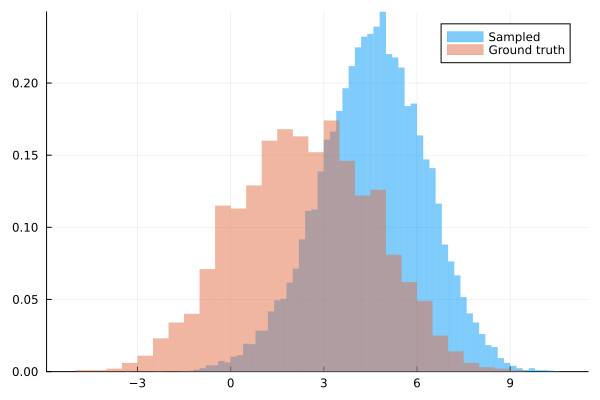

In [26]:
all_samples = vec(Array(posterior_check[:, 1:5, :]))
p = histogram(all_samples; normalize=:true, label="Sampled", opacity=0.5, linewidth=0, linecolor=:match)
p = histogram!(p, data; normalize=:true, label="Ground truth", opacity=0.5, linewidth=0, linecolor=:match)
p

Similar to how posterior predictive checks can be used to check the plausibility of the inferred posterior, a prior predictive check can be used to check the sensibility of our choice of priors. For that, we first want to sample from the prior, ignoring the data:

In [27]:
lr_chain_prior = sample(lr_model, Prior(), 1_000; progress=false)

Chains MCMC chain (1000×6×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.25 seconds
Compute duration  = 0.25 seconds
parameters        = slope, intercept, noise_variance
internals         = lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


And then `predict` data from those prior samples, and see if it looks at all reasonable:

In [28]:
prior_check = predict(lr_model_unconditioned, lr_chain_prior)

Chains MCMC chain (1000×2000×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9], data[10], data[11], data[12], data[13], data[14], data[15], data[16], data[17], data[18], data[19], data[20], data[21], data[22], data[23], data[24], data[25], data[26], data[27], data[28], data[29], data[30], data[31], data[32], data[33], data[34], data[35], data[36], data[37], data[38], data[39], data[40], data[41], data[42], data[43], data[44], data[45], data[46], data[47], data[48], data[49], data[50], data[51], data[52], data[53], data[54], data[55], data[56], data[57], data[58], data[59], data[60], data[61], data[62], data[63], data[64], data[65], data[66], data[67], data[68], data[69], data[70], data[71], data[72], data[73], data[74], data[75], data[76], data[77], data[78], data[79], data[80], data[81], data[82], data[83], data[84], data[85], data[86], d

For this, we can consider each sample in the chain to correspond to one possible linear regression model, and we can plot the data for a few of them.

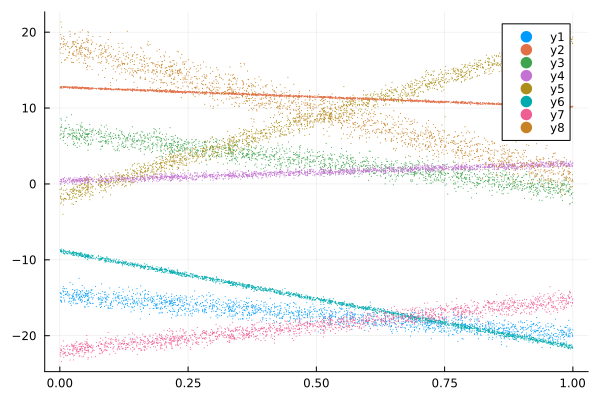

In [29]:
p = plot()
for i in 1:8
    prior_check_data = vec(Array(prior_check[i, :, :]))
    scatter!(p, predictors, prior_check_data, markersize=0.6, markerstrokewidth=0)
end
p

Looks reasonable enough. This is of course a check we should have done _before_ running inference, when we were writing the model and deciding on priors.

## Other inference methods

We've so far used the NUTS MCMC sampler, and a tiny bit of Metropolis-Hastings. Turing also has many more samplers, and inference methods other than Monte Carlo sampling.

### Markov Chain Monte Carlo samplers

We won't exhaustively cover the various Markov Chain Monte Carlo samplers Turing has, but to highlight a few:

- `NUTS` is a good default and a starting point. It is the most widely used sampler in the probabilistic programming world.
- `HMC`, for Hamiltonian Monte Carlo, is like `NUTS`, but with more parameters you need to choose manually. You may need to resort to it as a component sampler in Gibbs sampling (see below).
- `MH`, for Metropolis-Hastings, does both the classic random walk Metropolis-Hastings algorithms and static proposals. It's rarely more performant than NUTS or HMC, but doesn't require the model to be differentiable.
- `ESS`, for Elliptical Slice Sampling, is very efficient but only works for variables whose priors are (multivariate) normal distributions.
- `PG`, for particle Gibbs, is an interesting case: It's often slower than the other samplers, but it can also handle things the others can't. Namely, it can deal with discrete variables and variables with changing dimensionalities.

And then there's `Gibbs`. Gibbs isn't so much a sampler, but a metasampler: It allows you to take turns sampling different variables in your model with different samplers.

For instance, we could use ESS to sample the slope and the intercept for the linear regression model, while using HMC for the `noise_variance` variable (since its prior is not normal), like this:

In [30]:
sampler = Gibbs((:slope, :intercept) => ESS(), :noise_variance => MH([0.1;;]))
lr_chain_gibbs = sample(lr_model, sampler, MCMCThreads(), 1_000, 3; progress=false)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/mhauru/.julia/packages/AbstractMCMC/mcqES/src/sample.jl:432


Chains MCMC chain (1000×6×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 8.62 seconds
Compute duration  = 8.56 seconds
parameters        = slope, intercept, noise_variance
internals         = lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


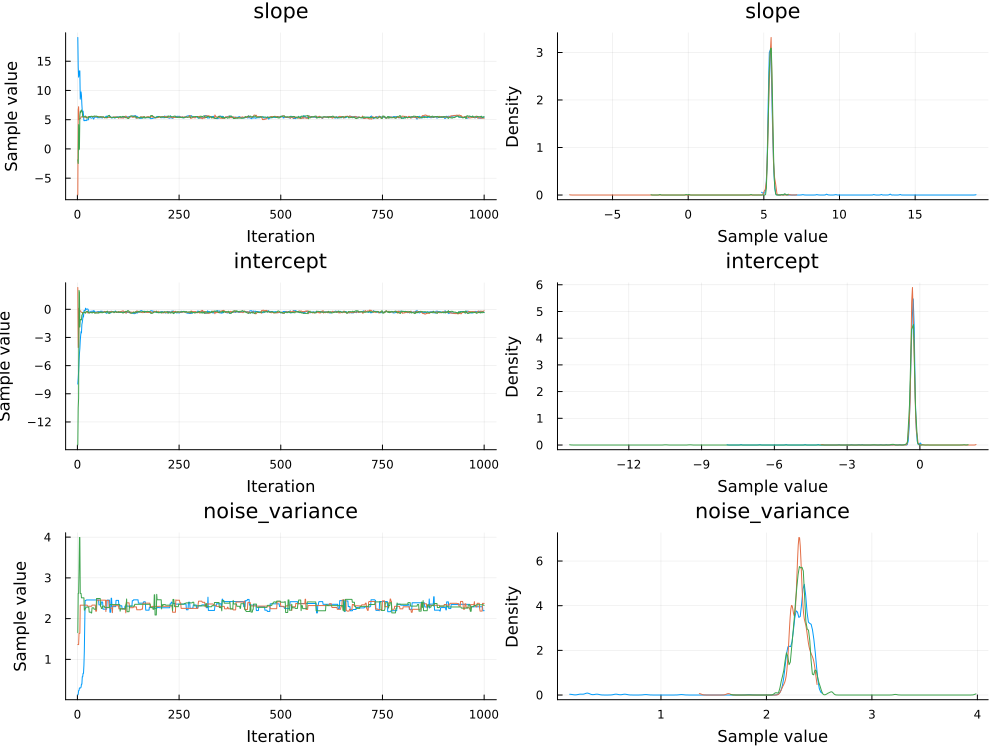

In [31]:
plot(lr_chain_gibbs)

All of these sampler algorithms also have a number of parameters you can tune, but we won't be diving into that now.

### Variational inference

Turing's heart is in MCMC sampling, but we do support other inference methods as well, namely variational inference and mode estimation.

Variational inference tries to find the best approximation to the posterior distribution by optimising within some parametrised family of distributions, e.g. the best Gaussian to fit the posterior. It doesn't come with the same robust convergence guarantees as MCMC, but can often be faster. You can use it in Turing like so:

In [35]:
q_init = q_meanfield_gaussian(lr_model)
q_fr, q_avg, info_fr, info_avg = lr_vi_result = vi(lr_model, q_init, 1000)

Optimizing   3%|▊                              |  ETA: 0:00:13 (13.37 ms/it)

Optimizing  12%|███▉                           |  ETA: 0:00:03 ( 3.67 ms/it)

Optimizing  22%|██████▉                        |  ETA: 0:00:02 ( 2.62 ms/it)

Optimizing  31%|█████████▌                     |  ETA: 0:00:02 ( 2.21 ms/it)

Optimizing  40%|████████████▍                  |  ETA: 0:00:01 ( 1.97 ms/it)

Optimizing  49%|███████████████▏               |  ETA: 0:00:01 ( 1.83 ms/it)

Optimizing  58%|██████████████████▏            |  ETA: 0:00:01 ( 1.70 ms/it)

Optimizing  68%|█████████████████████▏         |  ETA: 0:00:01 ( 1.61 ms/it)

Optimizing  77%|████████████████████████       |  ETA: 0:00:00 ( 1.55 ms/it)

Optimizing  87%|███████████████████████████▏   |  ETA: 0:00:00 ( 1.50 ms/it)

Optimizing  97%|██████████████████████████████ |  ETA: 0:00:00 ( 1.46 ms/it)

Optimizing 100%|███████████████████████████████| Time: 0:00:01 ( 1.46 ms/it)
   iteration: 1000
        elbo: -3696.9901398715806


(Bijectors.MultivariateTransformed{AdvancedVI.MvLocationScale{LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Normal{Float64}, Vector{Float64}}, Bijectors.Stacked{Vector{Function}, Vector{UnitRange{Int64}}}}(
dist: AdvancedVI.MvLocationScale{LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Normal{Float64}, Vector{Float64}}(
location: [5.436872613734795, -0.30170918071177644, 0.8397924150903261]
scale: Diagonal([0.05943932430895113, 0.03581655010456431, 0.033238878430498865])
dist: Normal{Float64}(μ=0.0, σ=1.0)
)

transform: Stacked(Function[identity, identity, Base.Fix1{typeof(broadcast), typeof(exp)}(broadcast, exp)], UnitRange{Int64}[1:1, 2:2, 3:3], UnitRange{Int64}[1:1, 2:2, 3:3])
)
, Bijectors.MultivariateTransformed{AdvancedVI.MvLocationScale{LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Normal{Float64}, Vector{Float64}}, Bijectors.Stacked{Vector{Function}, Vector{UnitRange{Int64}}}}(
dist: AdvancedVI.MvLocationScale{LinearAlgebra.Diagonal{Float64, Vector{Float64}}, Normal{

In [37]:
vi_samples = rand(q_avg, 100_000)

3×100000 Matrix{Float64}:
  5.3608     5.44585    5.37971   …   5.42654    5.28055    5.38265
 -0.280554  -0.329742  -0.372164     -0.290135  -0.364175  -0.237644
  2.26846    2.38809    2.3007        2.43089    2.24528    2.26009

In [40]:
vi_chain = Chains(reshape(vi_samples', (100_000, 3, 1)), [:slope, :intercept, :noise_variance])

Chains MCMC chain (100000×3×1 reshape(adjoint(::Matrix{Float64}), 100000, 3, 1) with eltype Float64):

Iterations        = 1:1:100000
Number of chains  = 1
Samples per chain = 100000
parameters        = slope, intercept, noise_variance

Use `describe(chains)` for summary statistics and quantiles.


In [41]:
quantile(vi_chain)

Quantiles

      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

           slope    5.3067    5.3765    5.4132    5.4500    5.5199
       intercept   -0.4101   -0.3646   -0.3409   -0.3174   -0.2725
  noise_variance    2.1946    2.2890    2.3397    2.3918    2.4958



### Mode estimation

Mode estimation refers to finding, not the full posterior distribution, but just the set of parameter values for which the probability density if the highest, i.e. the mode of the distribution. This is also called maximum a posteriori or MAP estimation. Alternatively one can find the mode of, not the posterior, but just the likelihood, called maximum likelihood estimation or MLE.

Turing has functions for both of these:

In [43]:
map_result = maximum_a_posteriori(lr_model)
mle_result = maximum_likelihood(lr_model)

ModeResult with maximized lp of -3678.29
[5.436400939075801, -0.30130916940174124, 2.317322442034621]

Let's check how the found modes look with respect to the earlier histogram of samples.

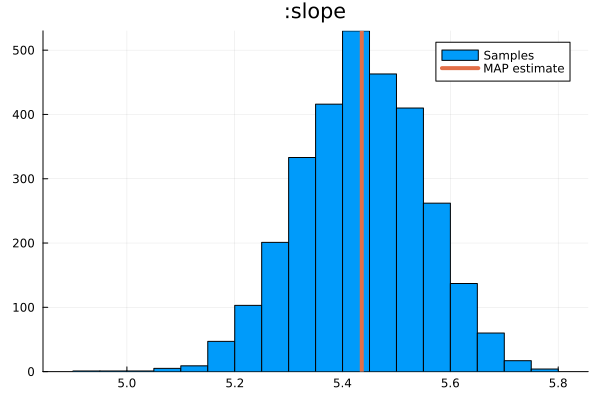

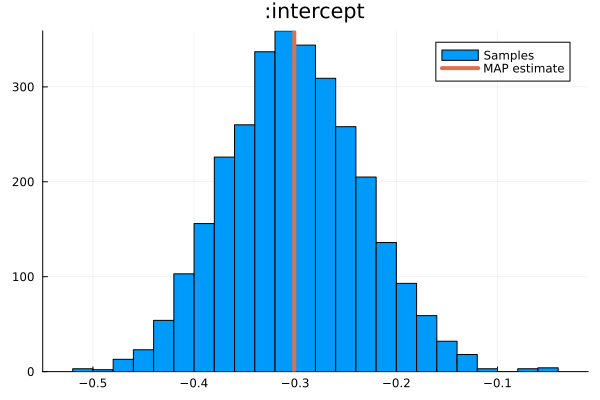

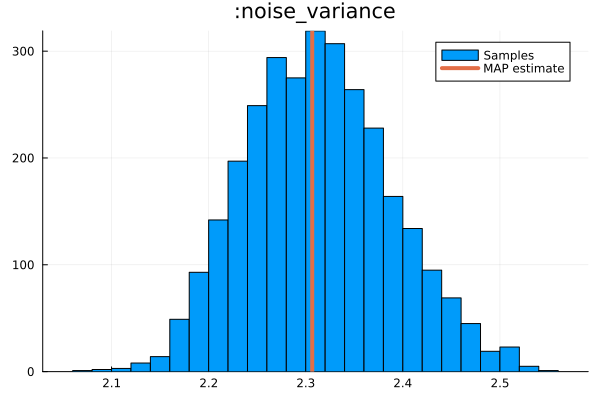

In [76]:
for name in names(lr_chain, :parameters)
    p = plot(; title=repr(name))
    p = histogram!(p, vec(Array(lr_chain[:,name,:])), label="Samples")
    p = vline!(p, [map_result.values[name]], linewidth=4, label="MAP estimate")
    display(p)
end

## Exercise: Try different inference methods

Task: Take linear regression model you wrote earlier, and try various inference methods on it, as well as different ways of investigating the results. For instance:
* Try using a different MCMC sampler. Check the results to see if they've converged nicely. If not, check the documentation for your chosen sampler over at https://turinglang.org/Turing.jl/stable/api/Inference/, and see if adjusting some of the parameters makes a difference.
* Try using variational inference. Maybe try different variational families, such as `q_meanfield_gaussian` and `q_fullrank_gaussian`, see how they differ in performance.
* Do a posterior predictive check for a couple of different inference methods and see how they compare.
* Check how the different inference methods scale if you vary the amount of data you give to the model.
* Poke around, break things, ask questions.

In [79]:
# TODO Write some code here, see above